In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [109]:
df_train = pd.read_csv('customer_churn_dataset-training-master.csv')
df_test = pd.read_csv('customer_churn_dataset-testing-master.csv')

In [110]:
df_train.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [111]:
df_test.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [112]:
df1 = df_train.copy()

In [113]:
churn_rate = df_train['Churn'].mean()
print(f"Churn Rate: {churn_rate * 100:.2f}%")


Churn Rate: 56.71%


In [114]:
# Assuming 'Total_Spend' represents the total amount spent by each customer
arpu = df_train['Total Spend'].mean()  # Average revenue per user
customer_lifetime = 1 / churn_rate  # Average customer lifespan based on churn rate

clv = arpu * customer_lifetime
print(f"Estimated Customer Lifetime Value (CLV): {clv:.2f}")


Estimated Customer Lifetime Value (CLV): 1113.75


In [115]:
# Step 1: Filter churned customers (Churn == 1)
churned_customers = df_train[df_train['Churn'] == 1]

# Step 2: Calculate the average total spend of churned customers
average_spend_churned = churned_customers['Total Spend'].mean()

# Step 3: Calculate the total cost of churn
total_churned_customers = len(churned_customers)
cost_of_churn = average_spend_churned * total_churned_customers

# Output the result
print(f"Average Spend of Churned Customers: ${average_spend_churned:.2f}")
print(f"Total Cost of Churn: ${cost_of_churn:.2f}")


Average Spend of Churned Customers: $541.29
Total Cost of Churn: $135320840.60


In [116]:
# Assuming df is already loaded and churned customers are filtered
churned_customers = df_train[df_train['Churn'] == 1]

# Calculate the total revenue lost from churned customers (Total Spend)
revenue_impact_of_churn = churned_customers['Total Spend'].sum()

print(f"Revenue Impact of Churn: ${revenue_impact_of_churn:.2f}")


Revenue Impact of Churn: $135320840.60


In [117]:
# Define the churn reduction percentage (e.g., 20%)
churn_reduction_percentage = 0.01

# Calculate the potential revenue retained through churn prediction
potential_revenue_retained = revenue_impact_of_churn * churn_reduction_percentage

print(f"Potential Revenue Retained with Churn Prediction: ${potential_revenue_retained:.2f}")


Potential Revenue Retained with Churn Prediction: $1353208.41


# Data Preprocessing

In [118]:
df1.columns = [col.replace(' ','_') for col in df1.columns]

In [119]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage_Frequency    440832 non-null  float64
 5   Support_Calls      440832 non-null  float64
 6   Payment_Delay      440832 non-null  float64
 7   Subscription_Type  440832 non-null  object 
 8   Contract_Length    440832 non-null  object 
 9   Total_Spend        440832 non-null  float64
 10  Last_Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [120]:
df1.describe()

,CustomerID,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,225398.667955,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,129531.918550,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,2.000000,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,113621.750000,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,226125.500000,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,337739.250000,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,449999.000000,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [121]:
df1.drop('CustomerID', axis=1, inplace=True)

In [122]:
df1.isna().sum()

Age                  1
Gender               1
Tenure               1
Usage_Frequency      1
Support_Calls        1
Payment_Delay        1
Subscription_Type    1
Contract_Length      1
Total_Spend          1
Last_Interaction     1
Churn                1
dtype: int64

In [123]:
df1.dropna(inplace=True)

In [124]:
df1.duplicated().sum()

0

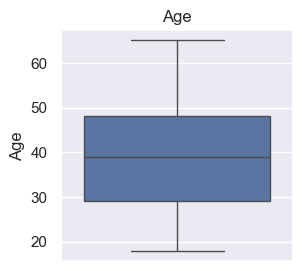

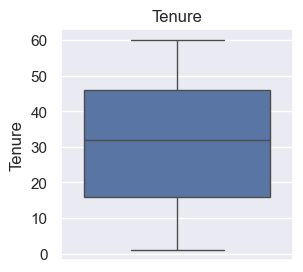

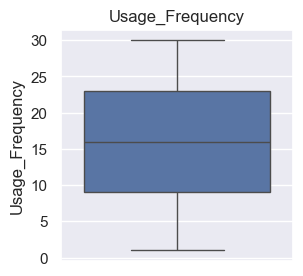

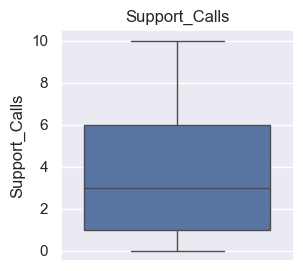

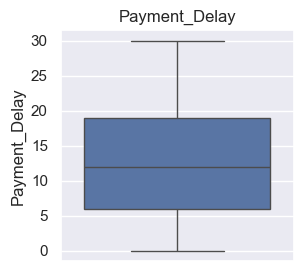

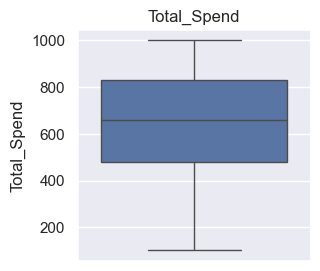

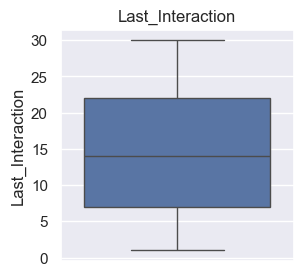

In [125]:
numerical_features = df1.select_dtypes('float').drop('Churn', axis=1)
import os

output_dir = 'boxplots'
os.makedirs(output_dir, exist_ok=True)

for feature in numerical_features:
    plt.figure(figsize=(3,3))
    sns.boxplot(df1[feature])
    plt.title(feature)
    plt.show()

    plt.savefig(os.path.join(output_dir, f'{feature}_boxplot.png'))
    plt.close()  # Close the figure to avoid display

In [126]:
categorical_features = df1.select_dtypes('object').columns.tolist()
categorical_features

['Gender', 'Subscription_Type', 'Contract_Length']

<Axes: xlabel='Gender'>

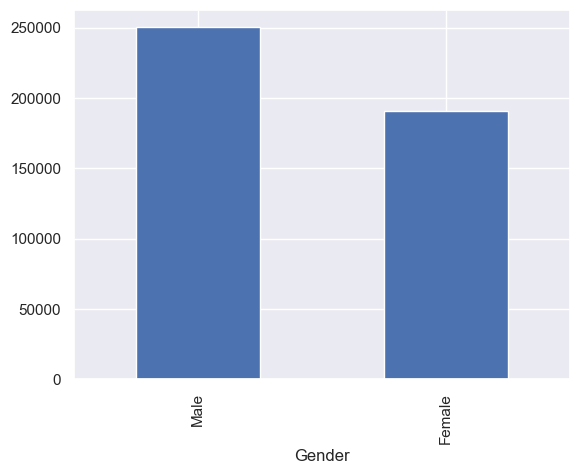

In [127]:
df1['Gender'].value_counts().plot.bar()

<Axes: xlabel='Subscription_Type'>

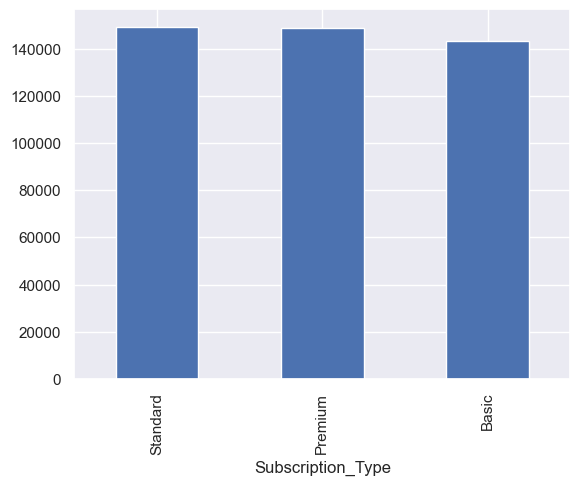

In [128]:
df1['Subscription_Type'].value_counts().plot.bar()

<Axes: xlabel='Contract_Length'>

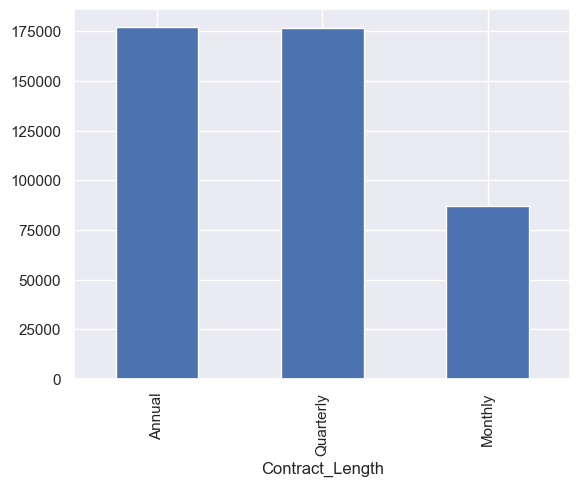

In [129]:
df1['Contract_Length'].value_counts().plot.bar()

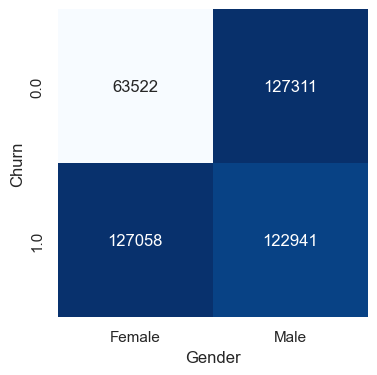

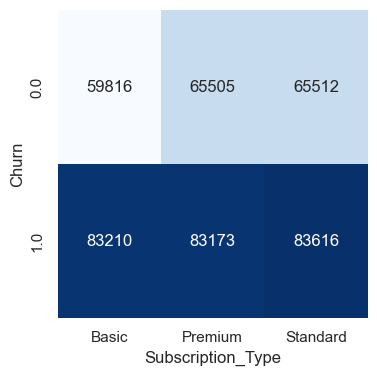

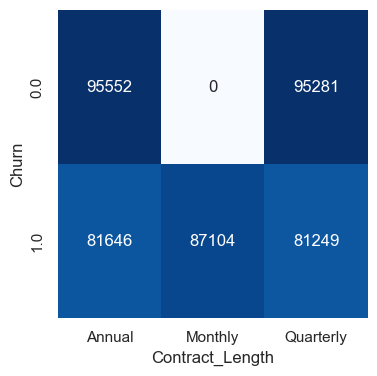

In [130]:
for feature in categorical_features:
    plt.figure(figsize=(4,4))
    sns.heatmap(pd.crosstab(df1['Churn'], df1[feature]), cmap='Blues', cbar=None, annot=True, fmt='d')

In [131]:
df1 = pd.get_dummies(df1, columns=categorical_features, drop_first=True, dtype='int')
df1 = df1[['Age', 'Tenure', 'Usage_Frequency', 'Support_Calls', 'Payment_Delay',
       'Total_Spend', 'Last_Interaction','Gender_Male',
       'Subscription_Type_Premium', 'Subscription_Type_Standard',
       'Contract_Length_Monthly', 'Contract_Length_Quarterly', 'Churn']]

In [132]:
df1.head()

,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Gender_Male,Subscription_Type_Premium,Subscription_Type_Standard,Contract_Length_Monthly,Contract_Length_Quarterly,Churn
0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,0,0,1,0,0,1.0
1,65.0,49.0,1.0,10.0,8.0,557.0,6.0,0,0,0,1,0,1.0
2,55.0,14.0,4.0,6.0,18.0,185.0,3.0,0,0,0,0,1,1.0
3,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1,0,1,1,0,1.0
4,23.0,32.0,20.0,5.0,8.0,617.0,20.0,1,0,0,1,0,1.0


In [133]:
numerical_features = list(df1.iloc[:,:-6])

scaler = StandardScaler()

for feature in numerical_features:
    df1[feature] = scaler.fit_transform(df1[[feature]])

In [134]:
df1.head()

,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Gender_Male,Subscription_Type_Premium,Subscription_Type_Standard,Contract_Length_Monthly,Contract_Length_Quarterly,Churn
0,-0.753326,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,0,0,1,0,0,1.0
1,2.059646,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,0,0,0,1,0,1.0
2,1.255940,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,0,0,0,0,1,1.0
3,1.497051,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,1,0,1,1,0,1.0
4,-1.315921,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,1,0,0,1,0,1.0


<Axes: >

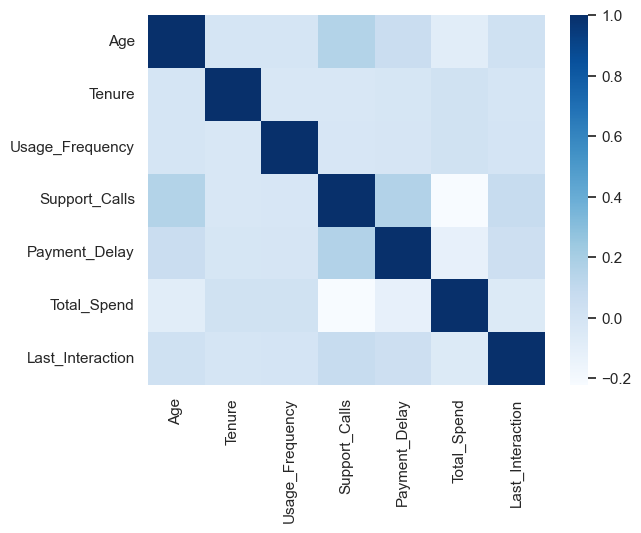

In [135]:
corr = df1[numerical_features].corr()
sns.heatmap(corr, cmap='Blues')

# Logistic Regression

In [136]:
X = df1.iloc[:,:-1]
y = df1.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True) #Splitting test and train data 70%-30%

In [137]:
print(f"Training dataset shape, X_train: {X_train.shape}, y_train: {y_train.shape}")

Training dataset shape, X_train: (308582, 12), y_train: (308582,)


In [138]:
print(f"Testing dataset shape, X_test: {X_test.shape}, y_test: {y_test.shape}")

Testing dataset shape, X_test: (132250, 12), y_test: (132250,)


In [139]:
X_train.head()

,Age,Tenure,Usage_Frequency,Support_Calls,Payment_Delay,Total_Spend,Last_Interaction,Gender_Male,Subscription_Type_Premium,Subscription_Type_Standard,Contract_Length_Monthly,Contract_Length_Quarterly
118311,1.979275,-0.130759,1.303541,1.105969,1.093996,-0.833114,1.456357,0,1,0,0,1
99593,0.050380,0.216952,-0.676373,0.128839,0.730714,-1.954364,1.340026,0,0,0,0,0
233797,0.291492,-1.231844,0.488282,2.083100,1.093996,0.337886,0.758374,0,0,1,1,0
406431,0.532604,1.144182,1.420007,0.128839,-0.359131,-0.150232,0.060391,1,0,1,0,1
138508,1.255940,-0.594374,1.070610,0.780259,0.125245,-0.289101,1.223696,1,0,0,1,0


In [140]:
y_train

118311    1.0
99593     1.0
233797    1.0
406431    0.0
138508    1.0
         ... 
259179    0.0
365839    0.0
131932    1.0
146867    1.0
121958    1.0
Name: Churn, Length: 308582, dtype: float64

In [187]:
lr = LogisticRegression(random_state=42, max_iter=500)

lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

In [188]:
def results(y_pred_lr):
    results = {}
    
    results['lr_accuracy'] = accuracy_score(y_test, y_pred)
    results['lr_precision'] = precision_score(y_test, y_pred)
    results['lr_recall'] = recall_score(y_test, y_pred)
    results['lr_f1_score'] = f1_score(y_test, y_pred)
    results['lr_roc_auc_score'] = roc_auc_score(y_test, y_pred)
    
    return results

In [189]:
results(y_pred_lr)

{'lr_accuracy': 0.8958487712665406,
 'lr_precision': 0.9267301375201826,
 'lr_recall': 0.8866693301371688,
 'lr_f1_score': 0.9062572311377898,
 'lr_roc_auc_score': 0.8972884789244275}

In [190]:
from sklearn.metrics import accuracy_score, classification_report
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

# Generate classification report
report = classification_report(y_test, y_pred_lr)
print("Classification Report:")
print(report)


Accuracy: 0.8923175803402646
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     57160
         1.0       0.92      0.88      0.90     75090

    accuracy                           0.89    132250
   macro avg       0.89      0.89      0.89    132250
weighted avg       0.89      0.89      0.89    132250



<Axes: >

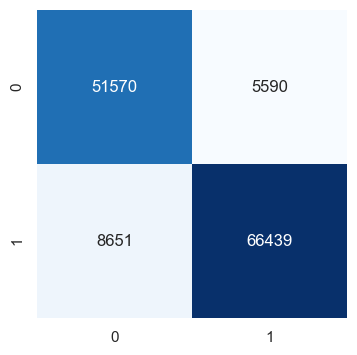

In [191]:
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=None)

In [195]:
low_important_features = coeff[abs(coeff['coeff']) < 0.4].T.keys().tolist()

In [196]:
low_important_features = [col for col in low_important_features if col in X_train.columns]
print(low_important_features)

[]


In [197]:
X_train = X_train.drop(low_important_features, axis=1)
X_test = X_test.drop(low_important_features, axis=1)

In [198]:
# Cross-validation and Hyperparameter Tuning
kf = KFold(shuffle=True, random_state=42, n_splits=3)
pf = PolynomialFeatures()

pipeline = Pipeline([
    ('polynomialfeatures', pf),
    ('lr', lr)
])

param_grid = {
    'polynomialfeatures__degree' : [3, 4, 5, 6, 7],
    'lr__C': [1e-2, 1e-1, 1e0, 1e1, 1e2],
}

grid = GridSearchCV(pipeline, param_grid, cv=kf, n_jobs=3, verbose=3, scoring='accuracy')

In [211]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88     57160
         1.0       0.92      0.88      0.90     75090

    accuracy                           0.89    132250
   macro avg       0.89      0.89      0.89    132250
weighted avg       0.89      0.89      0.89    132250



# Decision Tree

In [152]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt


In [153]:
# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42, max_depth=5)  # Specify max_depth to prevent overfitting

# Train the model
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)


In [175]:
# Evaluation function for Decision Tree
def evaluate_results(y_test, y_pred):
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc_score': roc_auc_score(y_test, y_pred)
    }
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return results

# Evaluate Decision Tree
metrics_dt = evaluate_results(y_test, y_pred_dt)
print("\nDecision Tree Metrics:")
print(metrics_dt)


Confusion Matrix:
[[57158     2]
 [ 2998 72092]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     57160
         1.0       1.00      0.96      0.98     75090

    accuracy                           0.98    132250
   macro avg       0.98      0.98      0.98    132250
weighted avg       0.98      0.98      0.98    132250


Decision Tree Metrics:
{'accuracy': 0.9773156899810964, 'precision': 0.9999722584403695, 'recall': 0.9600745771740578, 'f1_score': 0.9796173497119252, 'roc_auc_score': 0.9800197938354543}


In [181]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid Search
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Use the best model
best_dt = grid_search.best_estimator_


Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.988242999935836


In [182]:
# Train with best parameters
best_dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
best_dt.fit(X_train, y_train)


DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [158]:
# Predictions
y_pred_best_dt = best_dt.predict(X_test)

# Evaluate
final_metrics = evaluate_results(y_test, y_pred_best_dt)
print("\nFinal Decision Tree Metrics on Test Data:")
print(final_metrics)


Confusion Matrix:
[[57153     7]
 [  343 74747]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     57160
         1.0       1.00      1.00      1.00     75090

    accuracy                           1.00    132250
   macro avg       1.00      1.00      1.00    132250
weighted avg       1.00      1.00      1.00    132250


Final Decision Tree Metrics on Test Data:
{'accuracy': 0.9973534971644612, 'precision': 0.9999063595259117, 'recall': 0.99543214808896, 'f1_score': 0.9976642374736393, 'roc_auc_score': 0.9976548424139691}


In [212]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance)


Feature Importance:
                         Feature  Importance
1                  Support_Calls    0.369314
3                    Total_Spend    0.260564
5        Contract_Length_Monthly    0.139603
0                            Age    0.120572
2                  Payment_Delay    0.106040
6  Support_Calls_x_Payment_Delay    0.002118
4                    Gender_Male    0.001789
7             Age_Bin_Middle_Age    0.000000
8                 Age_Bin_Senior    0.000000
9                Age_Bin_Elderly    0.000000


# Random Forest Classifier

In [214]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, min_samples_leaf=4, min_samples_split=10)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
rf_metrics = evaluate_results(y_test, y_pred_rf)
print("\nRandom Forest Metrics:")
print(rf_metrics)

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance)


Confusion Matrix:
[[57158     2]
 [ 2006 73084]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     57160
         1.0       1.00      0.97      0.99     75090

    accuracy                           0.98    132250
   macro avg       0.98      0.99      0.98    132250
weighted avg       0.99      0.98      0.98    132250


Random Forest Metrics:
{'accuracy': 0.9848166351606805, 'precision': 0.9999726349779712, 'recall': 0.9732853908642962, 'f1_score': 0.9864485476730375, 'roc_auc_score': 0.9866252006805736}

Random Forest Feature Importance:
                         Feature  Importance
1                  Support_Calls    0.307199
3                    Total_Spend    0.234987
5        Contract_Length_Monthly    0.144710
0                            Age    0.141091
2                  Payment_Delay    0.126543
6  Support_Calls_x_Payment_Delay    0.038887
4                    Gender_Male    0.006582
7             Ag

# XG Boost

In [215]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(random_state=42, n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate
xgb_metrics = evaluate_results(y_test, y_pred_xgb)
print("\nXGBoost Metrics:")
print(xgb_metrics)

# Feature Importance
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(xgb_feature_importance)


Confusion Matrix:
[[57160     0]
 [ 1610 73480]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     57160
         1.0       1.00      0.98      0.99     75090

    accuracy                           0.99    132250
   macro avg       0.99      0.99      0.99    132250
weighted avg       0.99      0.99      0.99    132250


XGBoost Metrics:
{'accuracy': 0.9878260869565217, 'precision': 1.0, 'recall': 0.9785590624583833, 'f1_score': 0.9891633573399744, 'roc_auc_score': 0.9892795312291917}

XGBoost Feature Importance:
                         Feature  Importance
1                  Support_Calls    0.299440
3                    Total_Spend    0.268869
5        Contract_Length_Monthly    0.195286
2                  Payment_Delay    0.151889
0                            Age    0.067490
4                    Gender_Male    0.016796
6  Support_Calls_x_Payment_Delay    0.000231
7             Age_Bin_Middle_Age    0.00000

In [216]:
# Summarize Metrics
models_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_metrics['accuracy'], metrics_dt['accuracy'], rf_metrics['accuracy'], xgb_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], metrics_dt['precision'], rf_metrics['precision'], xgb_metrics['precision']],
    'Recall': [lr_metrics['recall'], metrics_dt['recall'], rf_metrics['recall'], xgb_metrics['recall']],
    'F1-Score': [lr_metrics['f1_score'], metrics_dt['f1_score'], rf_metrics['f1_score'], xgb_metrics['f1_score']],
    'ROC-AUC': [lr_metrics['roc_auc_score'], metrics_dt['roc_auc_score'], rf_metrics['roc_auc_score'], xgb_metrics['roc_auc_score']]
})

# Print Model Comparison
print("\nModel Comparison:")
print(models_performance)



Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.892318   0.922392  0.884792  0.903201  0.893498
1        Decision Tree  0.977316   0.999972  0.960075  0.979617  0.980020
2        Random Forest  0.984817   0.999973  0.973285  0.986449  0.986625
3              XGBoost  0.987826   1.000000  0.978559  0.989163  0.989280


<Figure size 600x600 with 0 Axes>

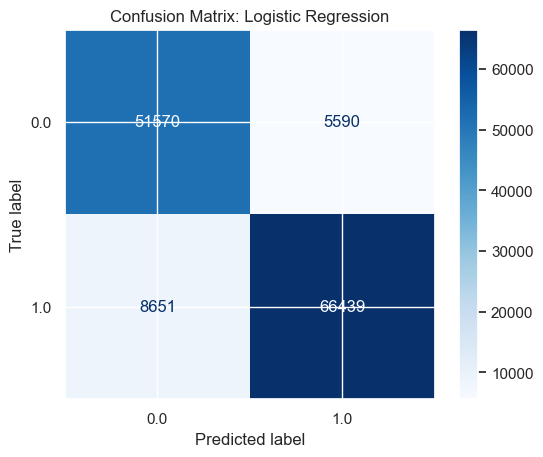

<Figure size 600x600 with 0 Axes>

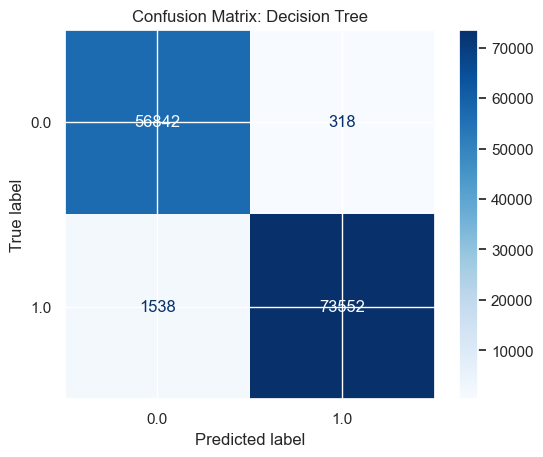

<Figure size 600x600 with 0 Axes>

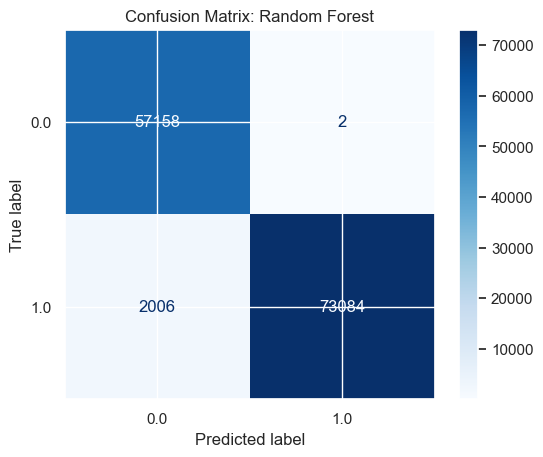

<Figure size 600x600 with 0 Axes>

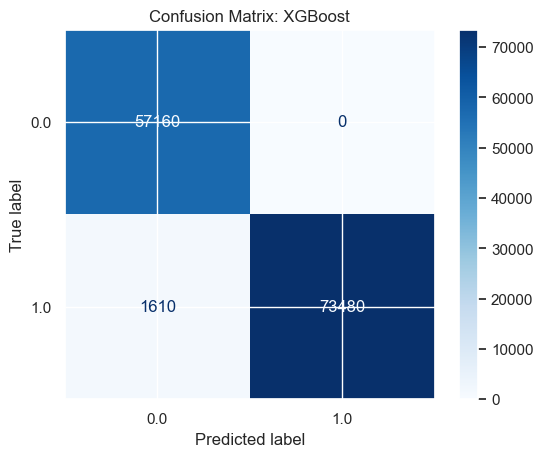

In [227]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define models and their corresponding predictions
models = {
    'Logistic Regression': lr,
    'Decision Tree': best_dt,  # Assuming best_dt is the best Decision Tree after tuning
    'Random Forest': rf,  # Assuming best_rf is the best Random Forest after tuning
    'XGBoost': xgb  # Assuming xgb is the trained XGBoost model
}

predictions = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb
}

# Save confusion matrices for each model
for model_name, model in models.items():
    plt.figure(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')